# Word Embeddings 

There are several ways of mapping words to vectors. Some of them are listed below:

i. Word2vec (By Google)

ii. Glove (By Stanford) (Uses Matrix Factorization. Given a corpus, build a co-occurrence matrix of the words in the vocabulary in the given context size. Kind of similar to Latent Semantic Analysis (LSA) )

iii. FastText (Introducted by Facebook):

   . Extension of Word2vec
   
   . Logic similar to Word2vec/Skip gram model
   
   . Word --> Subword information --> n-grams --> embeddings for n-grams
   
   . Word Embedding: Average of the n-gram embeddings
   
   . Useful when spell of queried word is not correct or words that are not present in the training data

iv. StarSpace (By Facebook)

v. RAND-WALK


Traditional appraoch: representing words based on one-hot representation, but words do not capture semantics. That is reason we go for word embeddings. In word embeddings, we can perform operations between words such as:

$$V(king) - V(man) + V(woman) = V(queen) $$

Words that occur in similar context tends to have similar meaning. 

# Import Dependencies

In [17]:
import codecs
import glob
import multiprocessing
import os
import pprint
import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim.models.word2vec as w2v
from gensim.models import FastText

import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Prepare Corpus

In [3]:
# Look harry porter books
book_filenames = sorted(glob.glob('../harry_poter_books/*.txt'))

# Combine books in one string
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print ""
    
# Tokenize into sentences
tokenized_sentences = sent_tokenize(corpus_raw)

print len(tokenized_sentences)


Reading '../harry_poter_books/book1.txt'...
Corpus is now 446557 characters long

Reading '../harry_poter_books/book2.txt'...
Corpus is now 947314 characters long

Reading '../harry_poter_books/book3.txt'...
Corpus is now 1581110 characters long

Reading '../harry_poter_books/book4.txt'...
Corpus is now 2701667 characters long

Reading '../harry_poter_books/book5.txt'...
Corpus is now 4216190 characters long

Reading '../harry_poter_books/book6.txt'...
Corpus is now 5215791 characters long

62576


### Tokenized sentences

In [4]:
#convert into a list of words
#remove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

#sentence where each word is tokenized
sentences = []
for raw_sentence in tokenized_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        


In [5]:

print(tokenized_sentences[5])
print(sentence_to_wordlist(tokenized_sentences[5]))

The Dursleys 
had a small son called Dudley and in their opinion there was no finer boy anywhere.
[u'The', u'Dursleys', u'had', u'a', u'small', u'son', u'called', u'Dudley', u'and', u'in', u'their', u'opinion', u'there', u'was', u'no', u'finer', u'boy', u'anywhere']


In [6]:
#count total number of sentences
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 918,059 tokens


In [7]:
# Train word2Vec
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 15

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()
# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

# Create and Train word2vec Model

In [8]:
# if sg = 1 then CBOW is used else skip-gram model
harryPorter2vec = w2v.Word2Vec(sentences,
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)


### Save word2vec model

In [9]:
# harryPorter2vec.build_vocab(sentences)
model_name = "PotterTrainedModel"
harryPorter2vec.save(model_name)

# load saved model

In [10]:
new_model = w2v.Word2Vec.load('PotterTrainedModel')

In [11]:
#list vocabulary
vocab = list(new_model.wv.vocab.keys())
print vocab[:160]

[u'exams', u'incantation', u'hats', u'personally', u'crumpled', u'yellow', u'sleek', u'four', u'Does', u'sleep', u'spiders', u'hanging', u'hate', u'pack', u'marching', u'trolley', u'whose', u'patches', u'swam', u'Diggory', u'containing', u'presents', u'slipping', u'whatsoever', u'under', u'teaching', u'sorry', u'pride', u'worth', u'Avada', u'placed', u'fists', u'Extendable', u'enonnous', u'louder', u'risk', u'rise', u'every', u'foul', u'utmost', u'bringing', u'vast', u'look', u'tickets', u'school', u'bewildered', u'wooden', u'Nice', u'frozen', u'Shacklebolt', u'red', u'greenish', u'Go', u'heading', u'triumph', u'clothes', u'enjoy', u'Leanne', u'Merlin', u'force', u'completely', u'tired', u'awake', u'feathers', u'Weasley', u'surrounding', u'likely', u'street', u'shrugging', u'air', u'quill', u'shining', u'blue', u'hide', u'Gilderoy', u'forgetting', u'painful', u'saved', u'cooking', u'Mudbloods', u'fingers', u'poison', u'lights', u'above', u'sideways', u'Put', u'new', u'tips', u'Sorcerer

In [12]:
len(new_model['Tuesday'])

/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


300

In [14]:
# Most similar words of tuesday
new_model.wv.most_similar('Tuesday', topn=10)

[(u'Day', 0.8891977667808533),
 (u'Wednesday', 0.8844271898269653),
 (u'finishing', 0.8748308420181274),
 (u'Last', 0.8691400289535522),
 (u'practices', 0.8658740520477295),
 (u'Thursday', 0.8646689653396606),
 (u'Sunday', 0.8599192500114441),
 (u'Today', 0.8598567247390747),
 (u'Friday', 0.859592080116272),
 (u'yesterday', 0.858914852142334)]

# Plot using TSNE

/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


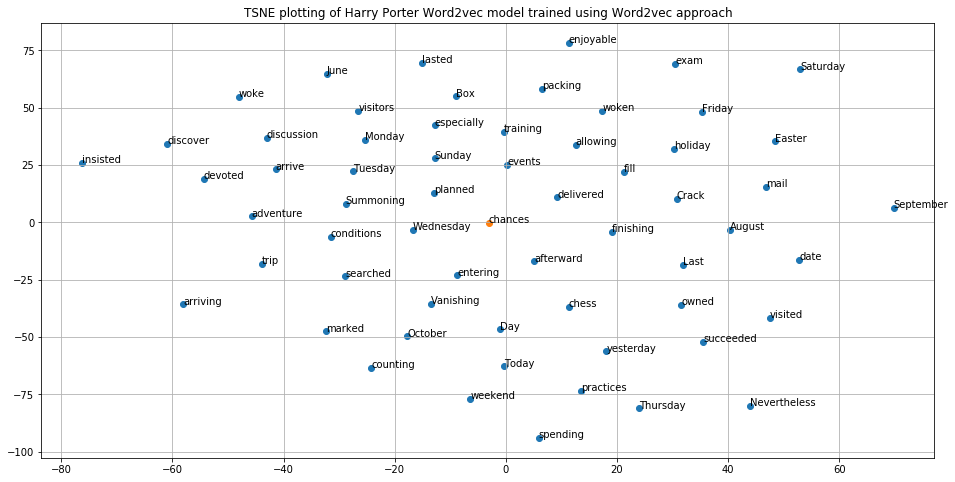

In [31]:
def TSNEPlot(model, word, dimension, text):
    
    #Empty vector, to append embeddings of closer/similar words
    embeddings_vector = np.empty((0,dimension), dtype='f')
    
    related_words = []
    related_words.append(word)
    queried_word_vector = (model[word])
    queried_word_vector = queried_word_vector.reshape(1,300)
    get_similar_words = model.wv.most_similar(word, topn=60)
    embeddings_vector = np.append(embeddings_vector, queried_word_vector, axis=0)
    
    for sim_word in get_similar_words:
        word = sim_word[0]
        word_vector = model[word]
        related_words.append(word)
        word_vector = word_vector.reshape(1,300)
        embeddings_vector = np.append(embeddings_vector, word_vector, axis=0)
    
    # Reduce 300 dimension into two dimension and do scatter plotting
    tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
    Y = tsne.fit_transform(embeddings_vector)
    plt.figure(figsize=(16,8))
    x_coords = Y[1:, 0]
    y_coords = Y[1:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(related_words, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.scatter([Y[0, 0]], [Y[0,1]])
    plt.annotate(word, xy=(Y[0,0], Y[0,1]), xytext=(0, 0), textcoords='offset points')
    plt.title(text)
    plt.grid(True)
    plt.show()
    
new_model = w2v.Word2Vec.load('PotterTrainedModel')
TSNEPlot(new_model, 'Tuesday', dimension = 300, text= "TSNE plotting of Harry Porter Word2vec model trained using Word2vec approach")

# Create and Train FastText Model

In [18]:
model_ted = FastText(sentences, size=num_features, window=context_size, min_count=min_word_count, workers=num_workers,sg=1)


In [19]:
model_name = "HarryPoterFastTextModel"
model_ted.save(model_name)

# Load Saved Model 

In [22]:
saved_model = FastText.load(model_name)

In [26]:
# first ten words in vocabulary
saved_model.wv.vocab.keys()[:10]

[u'exams',
 u'incantation',
 u'hats',
 u'personally',
 u'crumpled',
 u'yellow',
 u'sleek',
 u'four',
 u'Does',
 u'sleep']

In [27]:
saved_model.wv.most_similar('Tuesday', topn=10)

[(u'Wednesday', 0.9681217074394226),
 (u'Sunday', 0.9573895931243896),
 (u'Monday', 0.9551183581352234),
 (u'Thursday', 0.9516652822494507),
 (u'Today', 0.9445735216140747),
 (u'Friday', 0.943548858165741),
 (u'Saturday', 0.9259865283966064),
 (u'yesterday', 0.8977481722831726),
 (u'weekend', 0.8799175024032593),
 (u'holiday', 0.8678445219993591)]

/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/ramesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


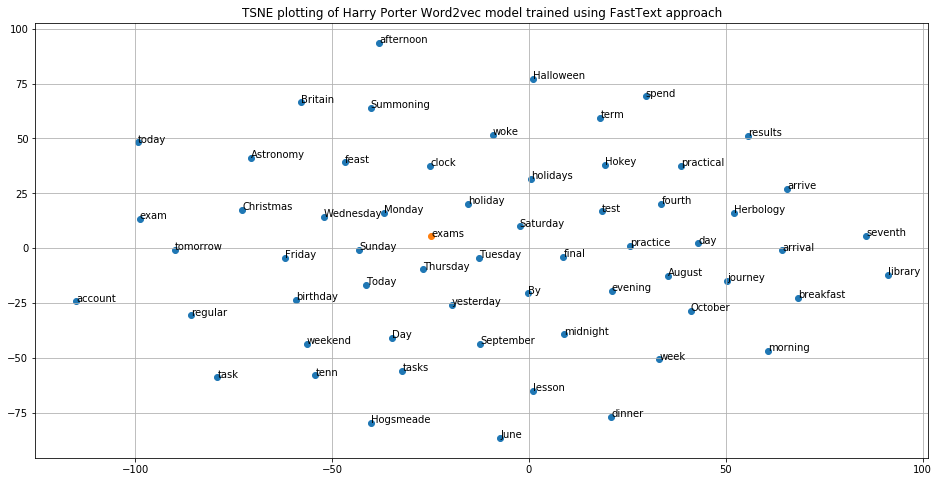

In [33]:
TSNEPlot(saved_model, 'Tuesday', dimension = 300, text= "TSNE plotting of Harry Porter Word2vec model trained using FastText approach")

# Word2vec Vs FastText

### Word2Vec

Word2Vec is an efficient solution to these problems, which leverages the context of the target words. Essentially, we want to use the surrounding words to represent the target words with a Neural Network whose hidden layer encodes the word representation.

There are two types of Word2Vec, Skip-gram and Continuous Bag of Words (CBOW).


#### Skip-gram (SG)

For skip-gram, the input is the target word, while the outputs are the words surrounding the target words. For instance, in the sentence “I have a cute dog”, the input would be “a”, whereas the output is “I”, “have”, “cute”, and “dog”, assuming the window size is 5. All the input and output data are of the same dimension and one-hot encoded. The network contains 1 hidden layer whose dimension is equal to the embedding size, which is smaller than the input/ output vector size. At the end of the output layer, a softmax activation function is applied so that each element of the output vector describes how likely a specific word will appear in the context. 

#### Continuous Bag of Words (CBOW)


Continuous Bag of Words (CBOW) is very similar to skip-gram, except that it swaps the input and output. The idea is that given a context, we want to know which word is most likely to appear in it.

The **biggest difference between Skip-gram and CBOW is that the way the word vectors are generated.** For CBOW, all the examples with the target word as target are fed into the networks, and taking the average of the extracted hidden layer. For example, assume we only have two sentences, “He is a nice guy” and “She is a wise queen”. To compute the word representation for the word “a”, we need to feed in these two examples, “He is nice guy”, and “She is wise queen” into the Neural Network and take the average of the value in the hidden layer. Skip-gram only feed in the one and only one target word one-hot vector as input.

It is claimed that Skip-gram tends to do better in rare words. Nevertheless, **the performance of Skip-gram and CBOW are generally similar.**

#### Limitations of Word2Vec

Although Word2Vec successfully handles the issue posed by one-hot vector, it has several limitation. The biggest challenge is that **it is not able to represent words that do not appear in the training dataset**. Even though using a larger training set that contains more vocabulary, some rare words used very seldom can never be mapped to vectors.


### FastText
FastText is an **extension to Word2Vec proposed by Facebook in 2016**. Instead of feeding individual words into the Neural Network, **FastText breaks words into several n-grams (sub-words)**. For instance, the tri-grams for the word apple is app, ppl, and ple (ignoring the starting and ending of boundaries of words). **The word embedding vector for apple will be the sum of all these n-grams**. After training the Neural Network, we will have word embeddings for all the n-grams given the training dataset. Rare words can now be properly represented since it is highly likely that some of their n-grams also appears in other words.